The copy of H-Siena Aug 13 to find the best model to descibe data

In [473]:
import numpy as np
import matplotlib.pyplot as plt

In [474]:
import emcee

In [475]:
import corner

In [476]:
import astropy.io.fits as fits

In [477]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [478]:
N_GC = data['NGCs']
Mag_z = data['Mag z']

In [479]:
err_GC = data['err GC']

In [480]:
a = np.argwhere(~np.isnan(Mag_z)) #find idx of non nan values in Mag z

In [481]:
print(len(a), len(Mag_z))

289 297


In [482]:
N_GC   = N_GC[a]
Mag_z  = Mag_z[a]
err_GC = err_GC[a]
#print(Mag_z)

In [483]:
#reshape from nx1 to n-dimensions array
N_GC   = N_GC.reshape((len(a)))
Mag_z  = Mag_z.reshape((len(a)))
err_GC = err_GC.reshape((len(a)))

<ErrorbarContainer object of 3 artists>

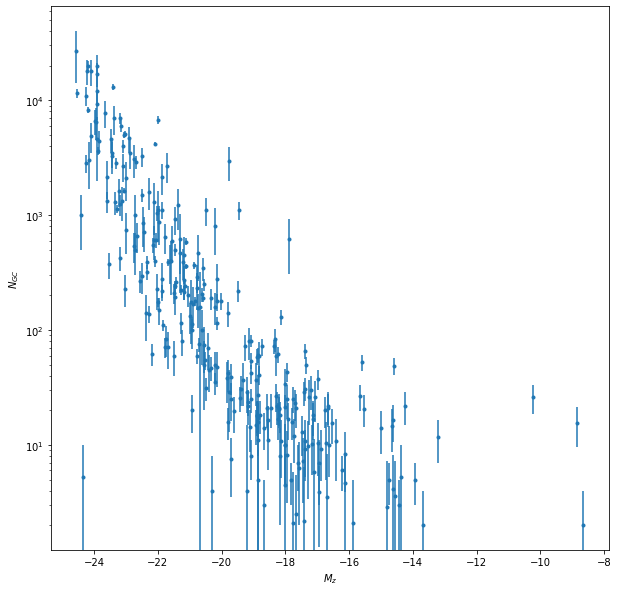

In [484]:
plt.figure(figsize=(10,10))
plt.xlabel('$M_z$')
plt.ylabel('$N_{GC}$')
plt.yscale('log')
plt.errorbar(Mag_z, N_GC, yerr = err_GC,fmt='.')

The fitting model could be

$ y(x) = N\left[a\left(\frac{x}{M_1}\right)^\alpha + b\left(\frac{x}{M_1}\right)^\beta \right]$

where x, y are magnitude and number of GCs, respectively; N, a, b, $\alpha, \beta, M_1$ are parameters.

-> find it doesnt work because of my bad data -> remove NaN value and do it again with full model!

In [485]:
def model(para, mag=Mag_z): #para = all parameters in the model, mag = x axis
    a, alpha, b, beta, M, N = para 
    model =  N*(a*(mag/M)**(alpha) + b*(mag/M)**beta)
    return model

 a, b = para define a function that return how good a fit our model is to the data, for the given set of parameters, weighted by the error in the data points (simple $\chi^2$ type check). 

\begin{align}
    L_{lnlike} = -0.5\sum \left(\frac{y-y_{model}}{y_{err}}\right)^2
\end{align}

- If the new model returns better fit compare to the default model (by an acceptance ratio), the walker will move toward that and repeat the process.

- Every walker keeps a record of $\theta$ and the likelihood of the model given data at value $\theta$.

- As if MCMC runs long enough to converge, it represents a sample of reasonable models to describe the data;



In [486]:
def lnlike(para, mag, y, yerr):
    lnlike = -0.5*np.sum(((y-model(para,mag))/yerr)**2)
    return lnlike

In [498]:
# the things we know (fact/conditions to the parameters)
def lnprior(para):
    a, alpha, b, beta, M,N= para 
    if  10 < a < 30 and 20 < alpha < 30 and 1<b<10 and 0<beta<2 and -22<M<-16 and 0<N<5: 
         return 0.0
    else:
        return -np.inf

In [499]:
# the function as lnprior output + lnlike output
def lnprob(para, mag, y, yerr):
    lp = lnprior(para)
    if not np.isfinite(lp): #check if input prior satisfy the parameter space
        return -np.inf
    return lp + lnlike(para, mag, y, yerr)

In [500]:
data     = (Mag_z, N_GC, err_GC)
nwalkers = 100
niter    = 10000
initial  = np.array([20, 25, 4, 0.5,-18, 2]) # initial set of values of the parameters (guess) [a, alpha, b, beta, norm, M1]
ndim     = len(initial)

# A list of the initial positions of the walkers in the parameter space. It should have the shape ``(nwalkers, dim)
#stepping from one place to the next, generate N-dimensional parameters space close to the current location
p0       = [np.array(initial) + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]

In [501]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim,lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [502]:
#run emcee to get posterior (pos), probability, state(?)
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


        At each iteration, this generator yields:

        * ``pos`` - A list of the current positions of the walkers in the
          parameter space. The shape of this object will be
          ``(nwalkers, dim)``.

        * ``lnprob`` - The list of log posterior probabilities for the
          walkers at positions given by ``pos`` . The shape of this object
          is ``(nwalkers, dim)``.


In [503]:
def plotter(sampler,mag=Mag_z, N=N_GC):
    plt.ion()
    plt.figure(figsize=(10,10))
    plt.yscale("log")
    plt.errorbar(Mag_z,N, yerr = err_GC,fmt='.',label='data')
    samples = sampler.flatchain
    for para in samples[np.random.randint(len(samples), size=10)]:
        plt.plot(Mag_z, model(para, Mag_z), '.',color='grey', alpha=0.3)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('$M_z$')
    plt.ylabel('$N_{GC}$')
    plt.legend()
    plt.show()

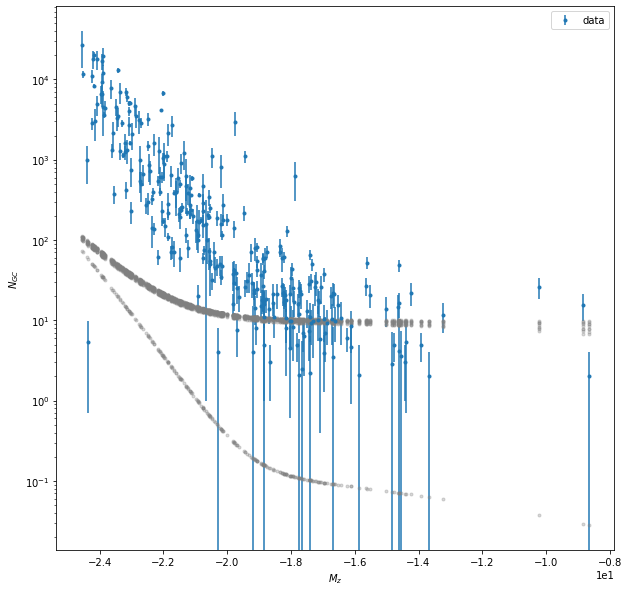

In [504]:
plotter(sampler)

Text(0.5, 0, 'step number')

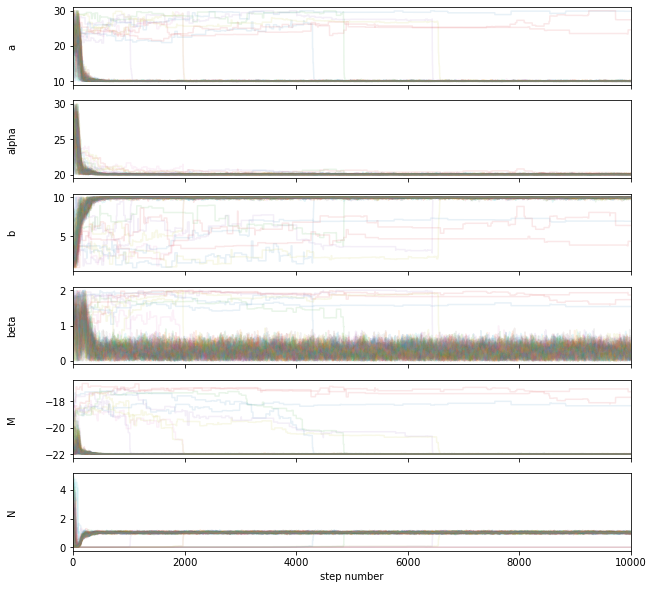

In [505]:
fig, axes = plt.subplots(6, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ['a', 'alpha','b','beta' ,'M','N']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i],alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [506]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.324


Text(0, 0.5, 'acceptance fraction')

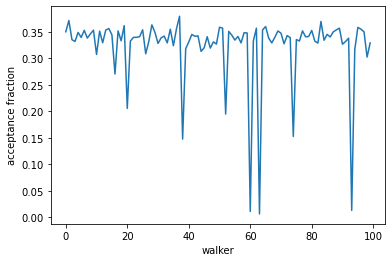

In [507]:
plt.plot(sampler.acceptance_fraction, '-')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [508]:
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [335.59052593 180.78474137 362.68400842 307.10428036 327.17678416
 278.2695511 ]

In [ ]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
#value of each parameter, highest likelihood model 

In [ ]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max,Mag_z)
plt.figure(figsize=(10,10))
plt.errorbar(Mag_z,N_GC,yerr=err_GC,fmt='.')
plt.plot(Mag_z,best_fit_model,'.',label='Highest Likelihood Model')
plt.yscale("log")
#plt.ylim(0,100)
plt.show()
print ('para max: ',theta_max)

In [ ]:
#posterior spread
fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
#fig = corner.corner(samples,show_titles=True,color='#097394',labels=labels, plot_datapoints= False,smooth=True,quantiles=[0.16, 0.5, 0.84])